In [0]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [0]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

Number of Training Examples = 200000
Number of Test Examples = 200000
Training X Shape = (200000, 202)
Training y Shape = 200000
Test X Shape = (200000, 201)
Test y Shape = 200000
Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)
Index(['ID_code', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5',
       'var_6', 'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)


## **Feature Engineering and Data Augmentation**

#### **1. Separating Real/Synthetic Test Data and Magic Features**
Using unique value count in a row to identify synthetic samples. If a row has at least one unique value in a feature, then it is real, otherwise it is synthetic. This technique is shared by [YaG320](https://www.kaggle.com/yag320) in this kernel [List of Fake Samples and Public/Private LB split](https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split) and it successfuly identifies synthetic samples in entire test set. This way the unusual bumps on the distribution peaks of test set features are captured. The magic features are extracted from the combination of training set and real samples in the test set. 

In [0]:
test = test.drop(['ID_code'], axis=1).values

unique_count = np.zeros_like(test)

for feature in range(test.shape[1]):
    _, index, count = np.unique(test[:, feature], return_counts=True, return_index=True)
    unique_count[index[count == 1], feature] += 1
    
real_samples = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synth_samples = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print('Number of real samples in test set is {}'.format(len(real_samples)))
print('Number of synthetic samples in test set is {}'.format(len(synth_samples)))

Number of real samples in test set is 100000
Number of synthetic samples in test set is 100000


In [0]:
features = [col for col in train.columns if col.startswith('var')]
df_all = pd.concat([train, test.ix[real_samples]])

for feature in features:
    temp = df_all[feature].value_counts(dropna=True)

    train[feature + 'vc'] = train[feature].map(temp).map(lambda x: min(10, x)).astype(np.uint8)
    test[feature + 'vc'] = test[feature].map(temp).map(lambda x: min(10, x)).astype(np.uint8)

    train[feature + 'sum'] = ((train[feature] - df_all[feature].mean()) * train[feature + 'vc'].map(lambda x: int(x > 1))).astype(np.float32)
    test[feature + 'sum'] = ((test[feature] - df_all[feature].mean()) * test[feature + 'vc'].map(lambda x: int(x > 1))).astype(np.float32) 

    train[feature + 'sum2'] = ((train[feature]) * train[feature + 'vc'].map(lambda x: int(x > 2))).astype(np.float32)
    test[feature + 'sum2'] = ((test[feature]) * test[feature + 'vc'].map(lambda x: int(x > 2))).astype(np.float32)

    train[feature + 'sum3'] = ((train[feature]) * train[feature + 'vc'].map(lambda x: int(x > 4))).astype(np.float32) 
    test[feature + 'sum3'] = ((test[feature]) * test[feature + 'vc'].map(lambda x: int(x > 4))).astype(np.float32)
    
print('Training set shape after creating magic features: {}'.format(train.shape))
print('Test set shape after creating magic features: {}'.format(test.shape))

Training set shape after creating magic features: (200000, 1002)
Test set shape after creating magic features: (200000, 1001)


#### **2 Data Augmentation**
Oversampling the data increases CV and LB score significantly since the data is imbalanced. This oversampling technique is shared by [Jiwei Liu](https://www.kaggle.com/jiweiliu) in this kernel [LGB 2 leaves + augment](https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment).

In [0]:
def augment(x, y, t=2):
    
    xs, xn = [], []
    
    for i in range(t // 2):
        mask = y == 0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        featnum = x1.shape[1] // 200 - 1

        for c in range(200):
            np.random.shuffle(ids)
            x1[:, [c] + [200 + featnum * c + idc for idc in range(featnum)]] = x1[ids][:, [c] + [200 + featnum * c + idc for idc in range(featnum)]]
        xn.append(x1)
    
    for i in range(t):
        mask = y > 0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        featnum = x1.shape[1] // 200 - 1
        
        for c in range(200):
            np.random.shuffle(ids)
            x1[:, [c] + [200 + featnum * c + idc for idc in range(1)]] = x1[ids][:, [c] + [200 + featnum * c + idc for idc in range(1)]]
        xs.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x, xs, xn])
    y = np.concatenate([y, ys, yn])
    
    return x, y

## **Model**

#### **LightGBM**

In [0]:
gbdt_param = {
    # Core Parameters
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 15,
    'tree_learner': 'serial',
    'num_threads': 8,
    'seed': SEED,
    
    # Learning Control Parameters
    'max_depth': -1,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 10,  
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'feature_fraction': 0.05,
    'lambda_l1': 1.,
    'bagging_seed': SEED,
    
    # Others
    'verbosity ': 1,
    'boost_from_average': False,
    'metric': 'auc',
}

In [0]:
predictors = train.columns.tolist()[2:]
X_test = test[predictors]

n_splits = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

oof = train[['ID_code', 'target']]
oof['predict'] = 0
predictions = test[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

In [0]:
for fold, (train_ind, val_ind) in enumerate(skf.split(train, train.target.values)):
    
    X_train, y_train = train.iloc[train_ind][predictors], train.iloc[train_ind]['target']
    X_valid, y_valid = train.iloc[val_ind][predictors], train.iloc[val_ind]['target']

    N = 1
    p_valid, yp = 0, 0
        
    for i in range(N):
        print('\nFold {} - N {}'.format(fold + 1, i + 1))
        
        X_t, y_t = augment(X_train.values, y_train.values)
        weights = np.array([0.8] * X_t.shape[0])
        weights[:X_train.shape[0]] = 1.0
        print('Shape of X_train after augment: {}\nShape of y_train after augment: {}'.format(X_t.shape, y_t.shape))
        
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t, weight=weights)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        
        lgb_clf = lgb.train(gbdt_param, trn_data, 100000, valid_sets=[trn_data, val_data], early_stopping_rounds=5000, verbose_eval=1000, evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
        
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    oof['predict'][val_ind] = p_valid / N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold + 1)] = yp / N



Fold 1 - N 1
Shape of X_train after augment: (336076, 1000)
Shape of y_train after augment: (336076,)
Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.959889	valid_1's auc: 0.884444
[2000]	training's auc: 0.969119	valid_1's auc: 0.90221
[3000]	training's auc: 0.974014	valid_1's auc: 0.910995
[4000]	training's auc: 0.977178	valid_1's auc: 0.915888
[5000]	training's auc: 0.979434	valid_1's auc: 0.91871
[6000]	training's auc: 0.981291	valid_1's auc: 0.920135
[7000]	training's auc: 0.982937	valid_1's auc: 0.921017
[8000]	training's auc: 0.984453	valid_1's auc: 0.921539
[9000]	training's auc: 0.985838	valid_1's auc: 0.921717
[10000]	training's auc: 0.987148	valid_1's auc: 0.921951
[11000]	training's auc: 0.988386	valid_1's auc: 0.92206
[12000]	training's auc: 0.989534	valid_1's auc: 0.922061
[13000]	training's auc: 0.99061	valid_1's auc: 0.922061
[14000]	training's auc: 0.991598	valid_1's auc: 0.922145
[15000]	training's auc: 0.992508	valid_1's auc: 

#### **ROC-AUC Score**

In [0]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])

print('Mean AUC: {}, std: {}.\nAll AUC: {}.'.format(mean_auc, std_auc, all_auc))

Mean AUC: 0.9232484959686411, std: 0.0029470219255069616.
All AUC: 0.9230899950649152.


#### **Feature Importance**

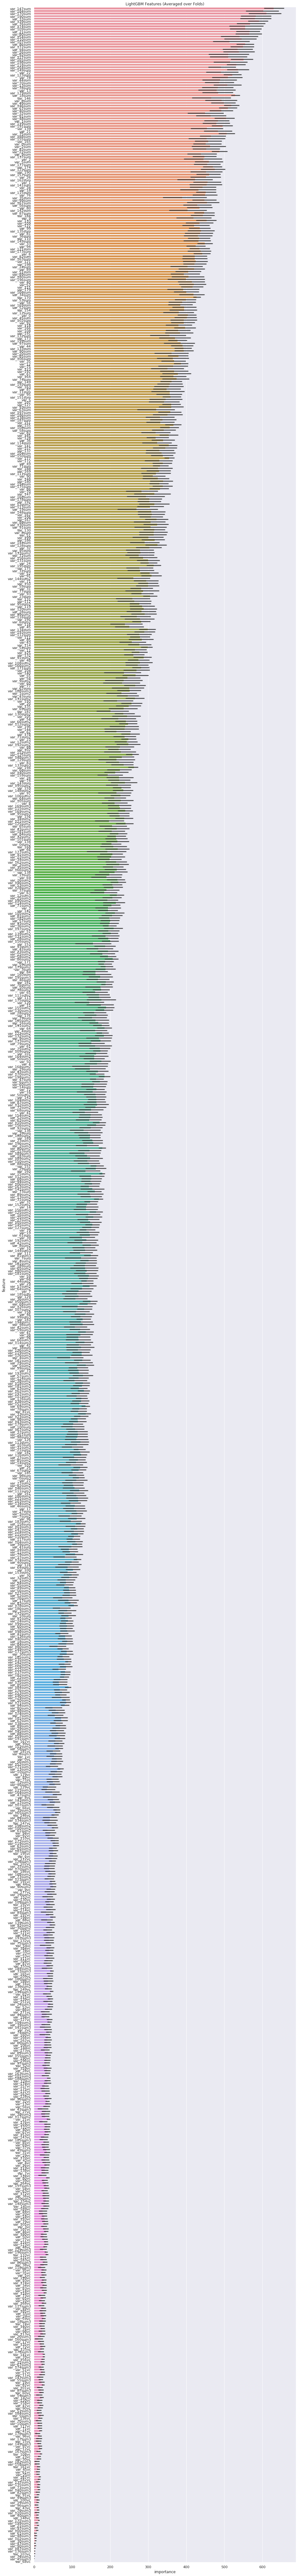

In [0]:
cols = (feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(15, 150))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (Averaged over Folds)')
plt.show()

#### **Create Submission**

In [0]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission.csv", index=False)
oof.to_csv('lgb_oof.csv', index=False)

#### **Leaderboard Scores**
- **Public**: 0.92377
- **Private**: 0.92124